# Disposable Camera Effect Generator

This notebook transforms a digital image to resemble a photo from a disposable camera.
Key characteristics simulated:
* High ISO noise/grain
* Soft focus
* Warm, faded colors
* Flattened highlights and lifted shadows
* Green/Yellow/Blue color shifts
* High contrast
* Vignetting
* 4x6 Aspect Ratio

In [5]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

def show_image(img_array, title="Image"):
    """Helper to display images in the notebook."""
    if len(img_array.shape) == 3:
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

## Configuration
Set your target image path and tweak effect parameters here.

In [6]:
# --- INPUT ---
IMAGE_PATH = 'E:\\8_Life\\2025_08_14_France\\DSC00211.JPG'     # <--- Input Image
OUTPUT_FOLDER = 'C:\\Users\\peter\\Desktop\\vscode\\main\\photo\\02_Outputs' # <--- Export Directory (Optional)

# --- PARAMETERS ---
# All effects are controllable via these constants or by calling the functions directly.

# Aspect Ratio is auto-detected (4x6 or 6x4)

# Grain
GRAIN_INTENSITY = 0.2  # 0.0 to 1.0 (Higher = more grain)
ISO_LEVEL = 400        # Simulates ISO scaling

# Softness
SOFTNESS_RADIUS = 1.0 # Gaussian blur sigma. 0.5 to 2.0 is usually good.

# Color Grading
WARMTH_FACTOR = 1.2   # > 1.0 makes it warmer (redder), < 1.0 cooler.
GREEN_TINT = 1.05     # > 1.0 adds green
BLUE_TINT = 0.85      # < 1.0 reduces blue (faded look)

# Vintage Curves (Fading)
LIFT_SHADOWS = 30     # 0-255. Raises black point.
FLATTEN_HIGHLIGHTS = 230 # 0-255. Lowers white point.

# Contrast
CONTRAST_FACTOR = 1.2 # > 1.0 increases contrast.

# Vignette
VIGNETTE_STRENGTH = 0.6 # 0.0 to 1.0
VIGNETTE_RADIUS = 0.8  # Relative to image size

## Effect Functions

In [7]:
def apply_aspect_ratio(image, target_ratio=(4, 6)):
    """
    Crops the image to the specified aspect ratio (width, height).
    Default is 4x6 (Portrait). Use (6, 4) for Landscape.
    """
    h, w = image.shape[:2]
    current_ratio = w / h
    target_w, target_h = target_ratio
    desired_ratio = target_w / target_h

    if current_ratio > desired_ratio:
        # Image is too wide, crop width
        new_w = int(h * desired_ratio)
        start_x = (w - new_w) // 2
        return image[:, start_x:start_x+new_w]
    else:
        # Image is too tall, crop height
        new_h = int(w / desired_ratio)
        start_y = (h - new_h) // 2
        return image[start_y:start_y+new_h, :]

def add_grain(image, intensity=0.2):
    """
    Adds uniform noise to simulate film grain.
    Intensity scales the noise magnitude.
    """
    h, w, c = image.shape
    # Generate noise centered around 0
    noise = np.random.normal(0, intensity * 50, (h, w, c)).astype(np.float32)
    
    # Add noise to image
    noisy_image = image.astype(np.float32) + noise
    
    # Clip values to valid range
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def apply_softness(image, radius=1.0):
    """
    Applies slight Gaussian blur to soften the image.
    """
    # Kernel size must be odd. 0 means derived from sigma (radius)
    return cv2.GaussianBlur(image, (0, 0), radius)

def apply_color_balance(image, red_mult=1.0, green_mult=1.0, blue_mult=1.0):
    """
    Adjusts the intensity of R, G, and B channels individually.
    Input is BGR (standard OpenCV).
    """
    b, g, r = cv2.split(image)
    
    b = np.clip(b * blue_mult, 0, 255).astype(np.uint8)
    g = np.clip(g * green_mult, 0, 255).astype(np.uint8)
    r = np.clip(r * red_mult, 0, 255).astype(np.uint8)
    
    return cv2.merge((b, g, r))

def apply_vintage_curves(image, lift_shadows=30, flatten_highlights=230):
    """
    Simulates faded film by lifting shadows (blacks are gray) 
    and flattening highlights (whites are dull).
    Also applies an S-curve for contrast within the midtones if desired, 
    but here we focus on the fade.
    """
    # Create a Look-Up Table (LUT)
    lut = np.arange(256, dtype=np.uint8)
    
    # Linear interpolation for simple fade
    # 0 -> lift_shadows
    # 255 -> flatten_highlights
    
    # Formula: OUT = (IN / 255) * (High - Low) + Low
    min_v = lift_shadows
    max_v = flatten_highlights
    distance = max_v - min_v
    
    lut = (lut / 255.0) * distance + min_v
    lut = np.clip(lut, 0, 255).astype(np.uint8)
    
    return cv2.LUT(image, lut)

def apply_contrast(image, alpha=1.2):
    """
    Simple contrast adjustment.
    Alpha > 1.0 increases contrast.
    """
    return cv2.convertScaleAbs(image, alpha=alpha, beta=0)

def apply_vignette(image, strength=0.5, radius_scale=0.8):
    """
    Adds a dark vignette to the corners.
    scale: controls the size of the bright center.
    strength: controls how dark the corners get.
    """
    h, w = image.shape[:2]
    
    # Create Gaussian kernel
    X_kernel = cv2.getGaussianKernel(w, w * radius_scale)
    Y_kernel = cv2.getGaussianKernel(h, h * radius_scale)
    
    kernel = Y_kernel * X_kernel.T
    
    # Normalize kernel to 0-1 range and scale it
    mask = kernel / kernel.max()
    
    # Adjust strength: lower values in mask should be darker
    # We want center to be 1, corners to be (1 - strength)
    vignette_mask = mask * strength + (1 - strength)
    
    # Expand mask to 3 channels
    vignette_mask = cv2.merge([vignette_mask] * 3)
    
    # Apply
    output = image.astype(np.float32) * vignette_mask
    return np.clip(output, 0, 255).astype(np.uint8)

## Main Pipeline

Processing...
Detected Portrait (2656x3984). Using ratio 4x6.


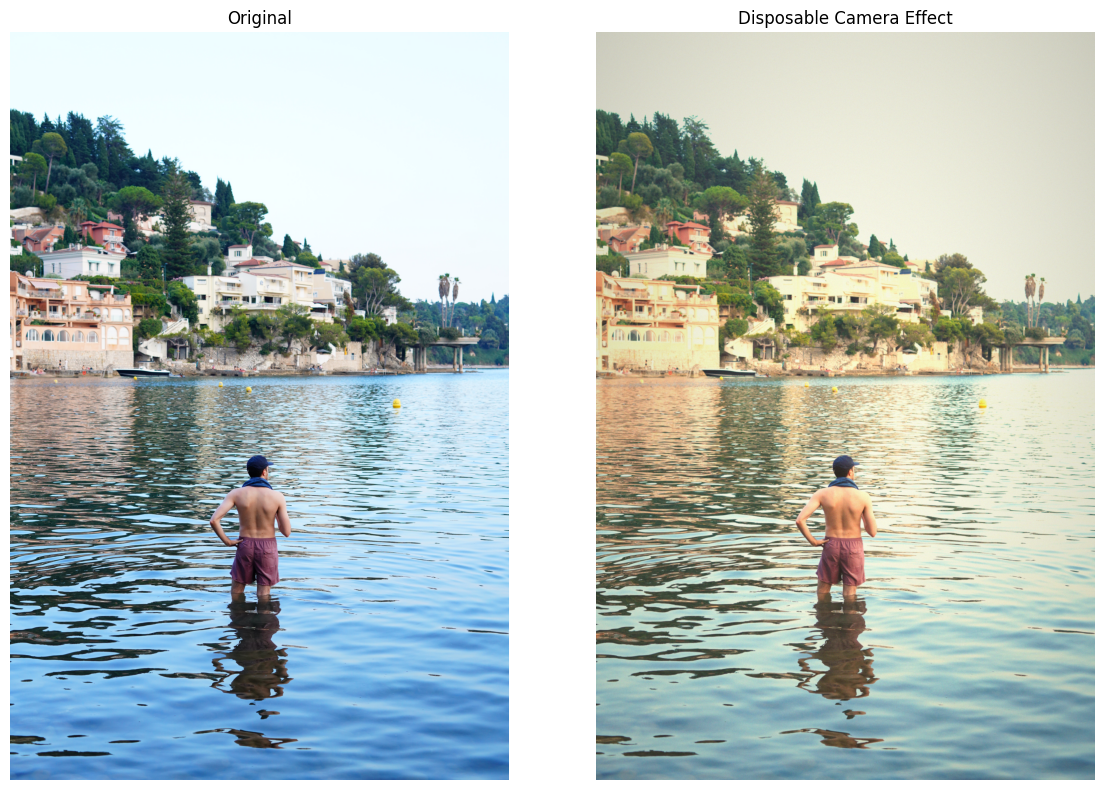


SUCCESS: Saved sRGB image to: C:\Users\peter\Desktop\vscode\main\photo\02_Outputs\DSC00211.JPG


In [ ]:
def process_image(img_path, output_folder=None):
    path = Path(img_path)
    if not path.exists():
        print(f"Error: File not found at {img_path}")
        return
    
    # 1. Load Image
    original = cv2.imread(str(path))
    if original is None:
        print("Error: Could not load image. Check format.")
        return
    
    print("Processing...")
    
    # 2. Aspect Ratio (Auto-detect orientation)
    h, w = original.shape[:2]
    if w > h:
        auto_ratio = (6, 4) # Landscape
        print(f"Detected Landscape ({w}x{h}). Using ratio 6x4.")
    else:
        auto_ratio = (4, 6) # Portrait
        print(f"Detected Portrait ({w}x{h}). Using ratio 4x6.")
        
    processed = apply_aspect_ratio(original, target_ratio=auto_ratio)
    
    # 3. Lift Shadows / Flatten Highlights (Vintage Curves)
    processed = apply_vintage_curves(processed, 
                                     lift_shadows=LIFT_SHADOWS, 
                                     flatten_highlights=FLATTEN_HIGHLIGHTS)
    
    # 4. Color Grading (Warmth + Tints)
    processed = apply_color_balance(processed, 
                                    red_mult=WARMTH_FACTOR, 
                                    green_mult=GREEN_TINT, 
                                    blue_mult=BLUE_TINT)
    
    # 5. Contrast
    processed = apply_contrast(processed, alpha=CONTRAST_FACTOR)
    
    # 6. Softness
    processed = apply_softness(processed, radius=SOFTNESS_RADIUS)
    
    # 7. Grain
    processed = add_grain(processed, intensity=GRAIN_INTENSITY)
    
    # 8. Vignette
    processed = apply_vignette(processed, 
                               strength=VIGNETTE_STRENGTH, 
                               radius_scale=VIGNETTE_RADIUS)
    
    # Show results
    plt.figure(figsize=(12, 8))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.title("Disposable Camera Effect")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 9. Save to Output Folder (if provided)
    if output_folder:
        out_dir = Path(output_folder)
        out_dir.mkdir(parents=True, exist_ok=True)
        output_path = out_dir / f'dce_{path.name}'
        
        # Convert BGR to RGB for PIL to ensure sRGB save
        rgb_processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_processed)
        
        # Save (PIL saves as sRGB by default unless specified otherwise)
        pil_image.save(str(output_path), "JPEG", quality=95)
        print(f"\nSUCCESS: Saved sRGB image to: {output_path}")
    
    return processed

# --- RUN HERE ---
# Ensure you set IMAGE_PATH (and optional OUTPUT_FOLDER) in the config cell above.
_ = process_image(IMAGE_PATH, OUTPUT_FOLDER)